In [1]:
# ----------------------------------------------------------------------------
# Author        :    Vasileios Perifanis
# Affiliation   :    Euclid team, Democritus University of Thrace, Dept. of Electrical & Computer Engineering
# Created Date  :    03/2022
# version       :    1.0
# ---------------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

import torch
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

# Training a model

In [3]:
data = pd.read_csv("datasets/purchase100.csv", header=0)

In [4]:
data.head()

,product_0,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9,...,product_591,product_592,product_593,product_594,product_595,product_596,product_597,product_598,product_599,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,72
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28


In [5]:
print(len(data), sorted(data['target'].value_counts(), reverse=True)[:10])

20000 [490, 382, 374, 320, 310, 305, 296, 292, 273, 265]


In [6]:
columns = list(data.columns)
columns = columns[:len(columns) - 1]
X = data.loc[:, columns].to_numpy()
y = data.target.to_numpy().ravel()

In [7]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, train_size=10_000, test_size=10_000,
                                                                                 random_state=0, shuffle=True)

In [8]:
len(indices_train), len(indices_test)

(10000, 10000)

In [9]:
indices_train

array([19879,  7502,  2745, ...,  9845, 10799,  2732])

In [10]:
membership = dict()
for idx in indices_train:
    membership[idx] = 1
for idx in indices_test:
    membership[idx] = 0

In [11]:
num_classes = len(np.unique(y_train))
counts_train = np.bincount(y_train)
counts_test = np.bincount(y_test)

print(f"Found {num_classes} classes")
print("Number of samples per class (train)", {i: counts_train[i] for i in range(len(counts_train))})
print("Number of samples per class (test)", {i: counts_test[i] for i in range(len(counts_test))})

Found 100 classes
Number of samples per class (train) {0: 98, 1: 163, 2: 113, 3: 103, 4: 164, 5: 128, 6: 68, 7: 47, 8: 114, 9: 70, 10: 83, 11: 94, 12: 88, 13: 71, 14: 94, 15: 92, 16: 164, 17: 52, 18: 151, 19: 115, 20: 114, 21: 108, 22: 97, 23: 99, 24: 96, 25: 89, 26: 76, 27: 84, 28: 113, 29: 93, 30: 73, 31: 75, 32: 106, 33: 112, 34: 80, 35: 115, 36: 129, 37: 114, 38: 85, 39: 99, 40: 110, 41: 97, 42: 112, 43: 111, 44: 121, 45: 107, 46: 252, 47: 83, 48: 114, 49: 68, 50: 86, 51: 104, 52: 106, 53: 99, 54: 127, 55: 135, 56: 90, 57: 99, 58: 118, 59: 44, 60: 105, 61: 82, 62: 78, 63: 102, 64: 94, 65: 89, 66: 104, 67: 109, 68: 98, 69: 74, 70: 190, 71: 102, 72: 71, 73: 78, 74: 86, 75: 110, 76: 126, 77: 39, 78: 81, 79: 94, 80: 69, 81: 117, 82: 93, 83: 137, 84: 72, 85: 17, 86: 75, 87: 80, 88: 88, 89: 68, 90: 113, 91: 87, 92: 104, 93: 105, 94: 96, 95: 94, 96: 97, 97: 186, 98: 98, 99: 80}
Number of samples per class (test) {0: 86, 1: 142, 2: 124, 3: 86, 4: 156, 5: 106, 6: 81, 7: 56, 8: 114, 9: 67, 1

In [12]:
class ClassifierDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)
    
def generate_dataset(train_x, train_y, batch_size, shuffle=True):
    dataset = ClassifierDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).long())
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

In [13]:
train_loader = generate_dataset(X_train, y_train, batch_size=1024, shuffle=True)
test_loader = generate_dataset(X_test, y_test, batch_size=1024, shuffle=True)

In [14]:
print(f"Training set size: ({X_train.shape},{y_train.shape}), Testing set size: ({X_test.shape},{y_test.shape})")

Training set size: ((10000, 600),(10000,)), Testing set size: ((10000, 600),(10000,))


In [15]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 128)
        self.out = torch.nn.Linear(128, num_classes)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [16]:
def test(model, data, criterion, prob=False):
    model.eval()
    loss, correct = 0., 0
    probabilities, labels = [], []
    if prob:
        softmax = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        for x, y in data:
            out = model(x)
            if prob:
                probability = softmax(out)
                probabilities.append(probability.flatten().tolist())
            loss += criterion(out, y).item()
            pred = out.argmax(dim=1)

            correct += int((pred == y).sum().item())
            labels.extend(y.tolist())
    loss = loss / len(data)
    accuracy = correct / len(data.dataset)

    if prob:
        return probabilities, loss, accuracy, np.array(labels)

    return loss, accuracy

def train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=1, plot=True):
    train_loss_history, train_acc_history = [], []  # track loss, accuracy
    test_loss_history, test_acc_history = [], []
    for epoch in range(1, epochs + 1):
        model.train()  # training mode
        for data, target in train_loader:
            optimizer.zero_grad()  # zero out gradients
            y_pred = model(data)  # forward propagation
            loss = criterion(y_pred, target)  # calculate loss
            loss.backward()  # backward pass, compute grads wrt to model parameters
            optimizer.step()  # update weights

        train_loss, train_acc = test(model, train_loader, criterion)  # test the model
        test_loss, test_acc = test(model, test_loader, criterion)

        train_acc_history.append(train_acc)  # keep metric history
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % log_interval == 0:  # log
            print(f"Epoch: [{epoch}/{epochs}]: Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
            print(f"\tEval Accuracy: {test_acc}, Loss: {test_loss:.4f}")

    if plot:  # plot history
        plt.plot(train_acc_history, label="Train Acc")
        plt.plot(test_acc_history, label="Test Acc")
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(train_loss_history, label="Train Loss")
        plt.plot(test_loss_history, label="Test Loss")
        plt.legend()
        plt.show()
        plt.close()

    return model

In [17]:
model = MLP(X_train.shape[1], num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
epochs = 150

Epoch: [20/150]: Accuracy: 0.8375, Loss: 0.7562
	Eval Accuracy: 0.6111, Loss: 1.1641
Epoch: [40/150]: Accuracy: 0.9651, Loss: 0.3192
	Eval Accuracy: 0.6392, Loss: 0.9974
Epoch: [60/150]: Accuracy: 0.9976, Loss: 0.1465
	Eval Accuracy: 0.634, Loss: 1.0105
Epoch: [80/150]: Accuracy: 0.9996, Loss: 0.0765
	Eval Accuracy: 0.6307, Loss: 1.0599
Epoch: [100/150]: Accuracy: 1.0000, Loss: 0.0458
	Eval Accuracy: 0.6286, Loss: 1.1111
Epoch: [120/150]: Accuracy: 1.0000, Loss: 0.0300
	Eval Accuracy: 0.6274, Loss: 1.1676
Epoch: [140/150]: Accuracy: 1.0000, Loss: 0.0210
	Eval Accuracy: 0.6231, Loss: 1.2130


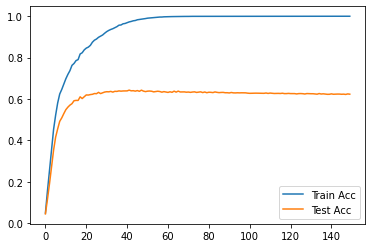

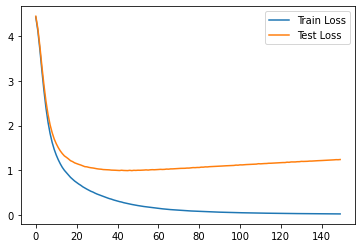

In [18]:
trained_model = train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=20, plot=True)

In [19]:
print("***Training Data Evaluation Example***")
test_loader = generate_dataset(X_train, y_train, batch_size=1)
probabilitites_train, test_loss, accuracy, _ = test(trained_model, test_loader, criterion, prob=True)
print(f"Accuracy: {accuracy:.4f}, loss: {test_loss:.4f}")

***Training Data Evaluation Example***
Accuracy: 1.0000, loss: 0.0178


In [20]:
print(probabilitites_train[0])

[4.510065654272921e-10, 1.4402822296863862e-19, 0.0010555378394201398, 2.0086326117615303e-26, 7.519299505347826e-26, 0.9864509105682373, 1.3488359229540947e-07, 2.5781162094062893e-08, 7.827067349808203e-08, 1.0228128760614297e-10, 1.4583264608923618e-13, 3.66936307727439e-11, 7.595274098548543e-08, 8.449340498373203e-07, 5.982212947230892e-09, 0.00012521936150733382, 5.383163842157424e-16, 1.493085655113191e-10, 7.490901887501067e-14, 8.30800406612348e-19, 7.348307207166727e-08, 0.0005710612167604268, 1.5657353287679143e-05, 4.2585986648191465e-07, 1.198275327851661e-07, 2.46782810954524e-16, 5.284137841954362e-06, 6.468336323450785e-06, 1.652916581385e-09, 5.066686545145138e-13, 4.867454841419282e-14, 2.1421953988465248e-07, 9.378335380461067e-05, 9.392020729137585e-05, 4.867888606991571e-15, 7.088438280788978e-08, 0.0008897242951206863, 0.0007801262545399368, 6.1136153931727664e-18, 4.02664915299944e-11, 6.193660624376207e-07, 8.604437552103817e-16, 3.016224694053077e-14, 0.0007876

In [21]:
idx = torch.argmax(torch.from_numpy(np.array(probabilitites_train[0])))
print(idx)
probabilitites_train[0][idx.item()]

tensor(5)


0.9864509105682373

In [22]:
print("***Testing Data Evaluation Example***")
test_loader = generate_dataset(X_test, y_test, batch_size=1, shuffle=False)
probabilitites_test, test_loss, accuracy, _ = test(trained_model, test_loader, criterion, prob=True)
print(f"Accuracy: {accuracy:.4f}, loss: {test_loss:.4f}")

***Testing Data Evaluation Example***
Accuracy: 0.6236, loss: 1.2378


In [23]:
print(probabilitites_test[:1])

[[5.286949544824893e-06, 0.008999655954539776, 1.1063260767565919e-12, 1.3767082236881834e-05, 2.031456233453355e-06, 3.958511570090195e-06, 5.056016161297805e-10, 6.992033174668677e-09, 6.828340670672617e-10, 1.0049336918172003e-09, 2.7673182856347012e-08, 1.9251689309385256e-07, 0.08515556901693344, 5.736045949333857e-08, 8.67825949990575e-12, 0.005498604383319616, 0.0002604014880489558, 2.144808604498394e-06, 1.9819806311716093e-06, 0.015228725969791412, 4.918910008200328e-07, 1.2811950111935033e-10, 2.460187999986374e-07, 0.20373089611530304, 2.0542745460261358e-07, 4.755416616042396e-10, 2.001654735295233e-07, 2.4645299134817833e-09, 2.456541096762521e-06, 8.15676345911065e-12, 5.311999284884905e-09, 8.869417700285709e-11, 2.1051691639906167e-11, 2.7693909032677766e-06, 1.3150218693375008e-14, 1.4559543615177972e-07, 1.2537644533683334e-10, 2.0698511793426633e-09, 0.0024799946695566177, 1.5814350717846537e-07, 1.3542970123125997e-07, 0.0016371774254366755, 0.003594280919060111, 1.

In [24]:
idx = torch.argmax(torch.from_numpy(np.array(probabilitites_test[0])))
print(idx)
probabilitites_test[0][idx.item()]

tensor(60)


0.6607639193534851

# Confidence-based Membership Inference (Black-Box Attack)

In [25]:
def threshold_membership_inference(target_model,
                                   threshold=0.9):
    
    # attacker gets a set of samples
    data = pd.read_csv('datasets/purchase100.csv', header=0)
    # print(data['target'].value_counts())

    columns = list(data.columns)
    columns = columns[:len(columns) - 1]
    X = data.loc[:, columns].to_numpy()
    y = data.target.to_numpy().ravel()

    num_classes = len(np.unique(y))
    dataset = X, y
    
    # attacker queries the model
    target_model.eval()
    
    softmax = torch.nn.Softmax(dim=0)
    target_correct = 0
    idx_membership = {}
    attack_correct = 0
    
    with torch.no_grad():
        for i in range(len(X)): # for each sample in the given dataset
            # transform to torch tensor
            tmp_x, tmp_y = torch.from_numpy(X[i]).float(), int(y[i])
            # query the model
            out = target_model(tmp_x)
            # get confidence scores
            probability = softmax(out) 
            pred = out.argmax().item() 
            if pred == tmp_y:
                target_correct += 1
            
            # get the maximum confidence score for a sample
            max_prob = torch.max(probability).item()
            # insert sample to members if max_prob > threshold
            if max_prob > threshold:
                membership_pred = 1
            else:
                membership_pred = 0
            idx_membership[i] = membership_pred
    print("Target Acc:", target_correct / len(X))
    return idx_membership        

In [26]:
predictions = threshold_membership_inference(trained_model,threshold=0.9)

Target Acc: 0.8118


In [27]:
def get_membership_score(membership, predictions):
    assert len(membership) == len(predictions)
    correct = 0
    y_true, y_pred = [], []
    for key in predictions:
        if predictions[key] == membership[key]:
            correct += 1
        y_true.append(membership[key])
        y_pred.append(predictions[key])
        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

    print(f"Correct predictions: {correct}/{len(predictions)}")
    print(f"Accuracy: {correct / len(predictions):.4f}")
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f"Attack Precision: {precision}")
    print(f"Attack Recall: {recall}")
    print(f"Advantage (= tpr - fpr): {tpr[1] - fpr[1]}")

In [28]:
get_membership_score(membership, predictions)

Correct predictions: 15750/20000
Accuracy: 0.7875
TP: 9996, TN: 5754, FP: 4246, FN: 4
Attack Precision: 0.7018677152085381
Attack Recall: 0.9996
Advantage (= tpr - fpr): 0.5750000000000001


# Correct-based Membership Inference (Black-Box Attack)

In [29]:
def correct_membership_inference(target_model):
    
    # attacker gets a set of samples
    data = pd.read_csv('datasets/purchase100.csv', header=0)
    # print(data['target'].value_counts())

    columns = list(data.columns)
    columns = columns[:len(columns) - 1]
    X = data.loc[:, columns].to_numpy()
    y = data.target.to_numpy().ravel()

    num_classes = len(np.unique(y))
    dataset = X, y
    
    # attacker queries the model
    target_model.eval()
    
    
    target_correct = 0
    idx_membership = {}
    attack_correct = 0
    
    with torch.no_grad():
        for i in range(len(X)): # for each sample in the given dataset
            # transform to torch tensor
            tmp_x, tmp_y = torch.from_numpy(X[i]).float(), int(y[i])
            # query the model
            out = target_model(tmp_x)
            # get confidence scores
            
            pred = out.argmax().item() 
            if pred == tmp_y:
                target_correct += 1
                membership_pred = 1
            else:
                membership_pred = 0
            
            idx_membership[i] = membership_pred
    print("Target Acc:", target_correct / len(X))
    return idx_membership 

In [30]:
predictions = correct_membership_inference(trained_model)
get_membership_score(membership, predictions)

Target Acc: 0.8118
Correct predictions: 13764/20000
Accuracy: 0.6882
TP: 10000, TN: 3764, FP: 6236, FN: 0
Attack Precision: 0.6159152500615915
Attack Recall: 1.0
Advantage (= tpr - fpr): 0.37639999999999996


# Limitations

- Which threshold is optimal for the threshold-based attack?
- What if the model generalizes well on unseen samples (correct-based attack)?

The above attack methods can only serve as baseline

## Solution: Shokri Attack (Training Shadow models)
[Shokri, Reza, Marco Stronati, Congzheng Song, and Vitaly Shmatikov. "Membership inference attacks against machine learning models." In 2017 IEEE symposium on security and privacy (SP), pp. 3-18. IEEE, 2017.](https://arxiv.org/abs/1610.05820)

- We observed that given a threshold on an overfitted model, an attacker can correctly predict the membership with high probability.

- The Shokri attack exploits the confidence scores. 
    - First, the attacker collects samples, similar to those used to train the target model and constructs a dataset, called shadow dataset. The target model is the model that the attacker wishes to assess its robustness against MIA. By collecting the shadow dataset, the attacker is aware of the features and the corresponding labels. There are many ways of collecting such samples in the real world:
            - Generation of synthetic data: The attacker can use statistical or Generative Adversarial Network (GAN) based methods to generate synthetic data.
            - Generation of random data: The attacker can generate random data and query the target model.
            - Collection of similar data: The attacker can collect similar datasets to that used to train the target model.
    - Second, the shadow dataset is used to train multiple machine learning models, called shadow models. The shadow models are intended to imitate the behavior of the target model. More precisely, the attacker splits the shadow dataset into training and testing sets (multiple times using disjoint sets if possible). Then it uses the training sets to generate multiple predictive models. Each sample belonging to the shadow training set of a shadow model is labeled as a member (1) and each sample belonging to the shadow testing set is labeled as a non-member (0).   
    - Finally, the confidence scores of the shadow models and the membership information are given as input to an attack model. On a higher level, the attack model is a binary classifier and is trained on the confidence scores of the shadow models and the target is the membership information of the shadow dataset, which is known to the attacker. 

# Extended Shokri Attack

It is observed that the corresponding confidence scores vary among classes. For instance, consider a scenario where the target model is generated on an imbalanced dataset comprising 10 classes. Assuming that class 10 has fewer samples, it is highly likely that the corresponding confidence scores may vary from the corresponding scores of the rest classes.

An extension to the Shokri attack is to enhance the training of the attack model. In this variant, the attacker generates an attack model for each class. In other words, the shadow training and testing sets of each shadow model are further divided by class, i.e., the attacker starts by the predictions of the samples belonging to class 0, then gets the samples belonging to class 1 and so forth. For each class, it initiates the training of an attack model. We end up with as many attack models as the number of classes on the original dataset. To evaluate the membership of a sample to the target model, the attacker first queries the target model. The target model responds with the confidence scores and hence, the attacker is aware of the corresponding label. Finally, the attacker selects the attack model generated using the predicted class and evaluates the membership of the sample.